In [1]:
from math import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from scipy.interpolate import lagrange
from scipy.optimize import curve_fit
import re
from scipy.stats import boxcox
from multiprocessing import Pool
from mpl_toolkits.basemap import Basemap as Basemap
import mplleaflet

#network analysis packages
import networkx as nx
import community
from community import community_louvain
import warnings
from matplotlib.collections import LineCollection

from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
import difflib #for finding closest word match
import os

In [2]:
f = pd.read_csv('airports.dat.txt', header = None)
f = f.rename(columns = {0: 'ID', 1: 'Name', 2: 'City', 3: 'Country', 4: 'IATA', 5: 'ICAO', 6: 'Latitude', 7: 'Longitude',
         8: 'Altitude', 9: 'Timezone', 10: 'DST', 11: 'Tz Database Timzone', 12: 'Type', 13: 'Source'})
#f = f[f['Country'] == 'United States']
f = f[['IATA', 'ICAO', 'Latitude', 'Longitude']]

In [3]:
f

,IATA,ICAO,Latitude,Longitude
0,GKA,AYGA,-6.081690,145.391998
1,MAG,AYMD,-5.207080,145.789001
2,HGU,AYMH,-5.826790,144.296005
3,LAE,AYNZ,-6.569803,146.725977
4,POM,AYPY,-9.443380,147.220001
...,...,...,...,...
7693,\N,ULDA,71.616699,52.478298
7694,\N,XIUW,51.849998,107.737999
7695,\N,ULLK,58.625000,31.385000
7696,CPO,SCAT,-27.261200,-70.779198


In [4]:
all_US_CA_emissions = pd.read_csv('all_US_CA_airport_emissions.csv')
#all_US_CA_emissions = all_US_CA_emissions[['Departure', 'Arrival', 'Fuel Consumption (kg)', 'CO2 (kg)', 'HC (kg)', 'CO (kg)', 'NOx (kg)', 'SN (kg)']]


In [5]:
ca_iata_codes = list(pd.read_csv('CA_airports.csv')['AIRPORTID'])
intra_CA = all_US_CA_emissions[all_US_CA_emissions.Departure.isin(ca_iata_codes)]
intra_CA = intra_CA[intra_CA.Arrival.isin(ca_iata_codes)]

In [6]:
def lat_lon_merge(airport_df, loc_df):
    #merge on departures
    dep_merge_icao = airport_df.merge(loc_df, left_on = 'Departure', right_on = 'IATA', how = 'left')
    dep_merge_icao = dep_merge_icao.drop(['IATA'], axis = 1).dropna()
    dep_merge_iata = airport_df.merge(loc_df, left_on = 'Departure', right_on = 'ICAO', how = 'left')
    dep_merge_iata = dep_merge_iata.drop(['ICAO','IATA'], axis = 1).dropna()
    dep_merge = pd.concat([dep_merge_icao, dep_merge_iata], axis = 0, ignore_index = True).drop(['ICAO'], axis = 1)
    dep_merge = dep_merge.rename(columns = {'Latitude': 'Dep Lat', 'Longitude': 'Dep Lon'})

    #merge on arrivals
    arr_merge_icao = dep_merge.merge(loc_df, left_on = 'Arrival', right_on = 'IATA', how = 'left')
    arr_merge_icao = arr_merge_icao.drop(['IATA'], axis = 1).dropna()
    arr_merge_iata = dep_merge.merge(loc_df, left_on = 'Arrival', right_on = 'ICAO', how = 'left')
    arr_merge_iata = arr_merge_iata.drop(['ICAO','IATA'], axis = 1).dropna()
    arr_merge = pd.concat([arr_merge_icao, arr_merge_iata], axis = 0, ignore_index = True).drop(['ICAO'], axis = 1)
    arr_merge = arr_merge.rename(columns = {'Latitude': 'Arr Lat', 'Longitude': 'Arr Lon'})
    return arr_merge

In [7]:
CA_emissions = all_US_CA_emissions.groupby(['Departure', 'Arrival']).sum().reset_index()
CA_emissions_loc = lat_lon_merge(CA_emissions, f)

In [8]:
CA_emissions_loc['Route Type'] = ['US'] * len(CA_emissions_loc)
ca_iata_codes = list(pd.read_csv('CA_airports.csv')['AIRPORTID'])
intra_CA = CA_emissions_loc[CA_emissions_loc.Departure.isin(ca_iata_codes)]
intra_CA = intra_CA[intra_CA.Arrival.isin(ca_iata_codes)]
CA_emissions_loc.loc[intra_CA.index, 'Route Type'] = 'CA'

In [9]:
od_pairs = ['LAXSCK', 'LAXMMH', 'MMHSFO', 'LAXSGU', 'LAXSBA', 'SFOSTS', 'LAXSBP', 'MRYSFO', 'PSPSJC', 'LAXPSP', 
            'LAXMRY', 'BFLSFO', 'OTHSFO', 'LAXPRC', 'SBPSFO', 'FATLAX', 'OAKPSP', 'PDXSTS', 'RDDSFO', 'FATSAN',
            'MRYSAN', 'RDMSFO', 'LAXSAN', 'BFLPHX', 'LAXSTS', 'SNASTS', 'FATSFO', 'ACVSFO', 'LGBPHX', 'SBASFO',
            'PHXPSP']

In [10]:
def compare_od_pairs(row_index):
    alph_od_pair = ''.join(sorted([CA_emissions_loc.loc[row_index]['Departure'], CA_emissions_loc.loc[row_index]['Arrival']]))
    return alph_od_pair

od_pair_list = []
for qq in CA_emissions_loc.index:
    od_pair_list.append(compare_od_pairs(qq))
    
CA_emissions_loc.insert(2, 'OD Pair Name', od_pair_list)

In [11]:
regional_idx = CA_emissions_loc[CA_emissions_loc['OD Pair Name'].isin(od_pairs)].index
CA_emissions_loc.loc[regional_idx, 'Route Type'] = 'R'

In [12]:
CA_emissions_loc = CA_emissions_loc[['Departure', 'Arrival', 'OD Pair Name', 'Fuel Consumption (kg)',
                                     'CO2 (kg)', 'HC (kg)', 'CO (kg)', 'NOx (kg)', 'SN (kg)',
                                     'Dep Lat', 'Dep Lon', 'Arr Lat', 'Arr Lon', 'Route Type']]

In [13]:
route_type_regional = CA_emissions_loc[CA_emissions_loc['Route Type'] == 'R']
route_type_CA = CA_emissions_loc[CA_emissions_loc['Route Type'] == 'CA']
regional_route_airports = list(np.unique(list(route_type_regional['Departure']) + list(route_type_regional['Arrival'])))
CA_route_airports = list(np.unique(list(route_type_CA['Departure']) + list(route_type_CA['Arrival'])))
all_airports = list(np.unique(list(CA_emissions_loc['Departure']) + list(CA_emissions_loc['Arrival'])))

#create dictionary of route type airports
v = 'US'
route_type_node_dict = {k:v for k in all_airports}
for rr in CA_route_airports:
    route_type_node_dict[rr] = 'CA'
for tt in regional_route_airports:
    route_type_node_dict[tt] = 'R'

In [20]:
route_type_CA

,Departure,Arrival,OD Pair Name,Fuel Consumption (kg),CO2 (kg),HC (kg),CO (kg),NOx (kg),SN (kg),Dep Lat,Dep Lon,Arr Lat,Arr Lon,Route Type
14,ACV,BUR,ACVBUR,652.397588,2061.576377,1.168791,12.527211,61.314302,29.396542,40.978101,-124.109000,34.200699,-118.359001,CA
17,ACV,FAT,ACVFAT,426.933325,1349.109308,0.724871,8.033329,30.690964,14.848957,40.978101,-124.109000,36.776199,-119.718002,CA
19,ACV,LAX,ACVLAX,257547.840768,813851.176826,406.528113,4645.653737,27408.160742,11353.454751,40.978101,-124.109000,33.942501,-118.407997,CA
22,ACV,MRY,ACVMRY,169.841156,536.698053,0.199151,2.098770,12.418243,6.073225,40.978101,-124.109000,36.587002,-121.843002,CA
23,ACV,ONT,ACVONT,166.759628,526.960425,0.273891,2.729592,20.585938,9.834629,40.978101,-124.109000,34.056000,-117.600998,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,VNY,PSP,PSPVNY,449.120399,1419.220460,0.448728,4.442754,36.500590,14.463878,34.209801,-118.489998,33.829700,-116.507004,CA
2577,VNY,SFO,SFOVNY,1865.484889,5894.932248,2.058293,20.103205,271.466445,109.144928,34.209801,-118.489998,37.618999,-122.375000,CA
2578,VNY,SJC,SJCVNY,9342.758252,29523.116077,9.995283,97.908521,1222.032742,490.327302,34.209801,-118.489998,37.362598,-121.929001,CA
2579,VNY,TRM,TRMVNY,395.378707,1249.396713,0.485705,5.646123,14.629523,7.432347,34.209801,-118.489998,33.626701,-116.160004,CA


In [21]:
route_type_color_dict = {'US': '#d9d9d9', 'CA': '#527d3c', 'R': '#f55649'}
edge_color_list = list(CA_emissions_loc['Route Type'].map(route_type_color_dict))

In [43]:
fuel_consumption_regional = dict(zip(list(zip(list(route_type_CA['Departure']), list(route_type_CA['Arrival']))), list(route_type_CA['Fuel Consumption (kg)'])))


CO2_CA_network = dict(zip(list(zip(list(route_type_CA['Departure']), list(route_type_CA['Arrival']))), list(route_type_CA['CO2 (kg)'])))



In [24]:
edge_list = list(zip(list(CA_emissions_loc['Departure']), list(CA_emissions_loc['Arrival'])))
edge_color_dict = {}
edge_color_dict_geph = {}
#edge_color_fuel_consumption = {}
for idx, ee in enumerate(edge_list):
    edge_color_dict[ee] = edge_color_list[idx]
    edge_color_dict_geph[ee] = CA_emissions_loc.loc[idx, 'Route Type']
    #edge_color_fuel_consumption[ee] = CA_emissions_loc.loc[idx, 'Fuel Consumption (kg)']

In [44]:
def create_network(df, column_name = None):
    #create location dictionary for latitude and longitude of airports
    #lat_all = np.unique(pd.concat([df['Dep Lat'], df['Arr Lat']]))
    #lon_all = np.unique(pd.concat([df['Dep Lon'], df['Arr Lon']]))
    lat_lon_dict = {}
    for ii in df.index:
        lat_lon_dict[df.loc[ii]['Departure']] = (df.loc[ii]['Dep Lon'], df.loc[ii]['Dep Lat'])
        lat_lon_dict[df.loc[ii]['Arrival']] = (df.loc[ii]['Arr Lon'], df.loc[ii]['Arr Lat'])
    #create directed graph
    network = nx.DiGraph()
    for jj in df.index:
        network.add_edge(df.loc[jj]['Departure'], df.loc[jj]['Arrival'])
    
    #create dictionaries for edge and node attributes (latitude/longitude, edge color, etc)
    edge_list = list(network.edges())
    edge_color_list = []
    for ll in edge_list:
        edge_color_list.append(edge_color_dict[ll])
    latitude_dict = {}; longitude_dict = {};
    for nn in list(network.nodes()):
        latitude_dict[nn] = lat_lon_dict[nn][1]
        longitude_dict[nn] = lat_lon_dict[nn][0]
    
    #graphing parameters
    #xlim = [min(lon_all) - 1, max(lon_all) + 1]
    #ylim = [min(lat_all) - 0.5, max(lat_all) + 0.5]
    plt.subplots(figsize = (20, 13))
    nx.draw_networkx_edges(network, pos = lat_lon_dict, alpha = 1)
    nx.draw_networkx_nodes(network, pos = lat_lon_dict, node_size = 200, node_color = '#faa200', alpha = 0.8)
    nx.draw_networkx_labels(network, pos = lat_lon_dict, font_size = 10)
    
    #setting latitude and longitude attributes for graphing purposes in Gephi
    nx.set_node_attributes(network, latitude_dict, 'latitude')
    nx.set_node_attributes(network, longitude_dict, 'longitude')
    #nx.set_node_attributes(network, route_type_node_dict, 'route type')
    nx.set_edge_attributes(network, fuel_consumption_regional, 'fuel_consumption')
    nx.set_edge_attributes(network, CO2_CA_network, 'CO2_emissions')
    plt.show()
    return network

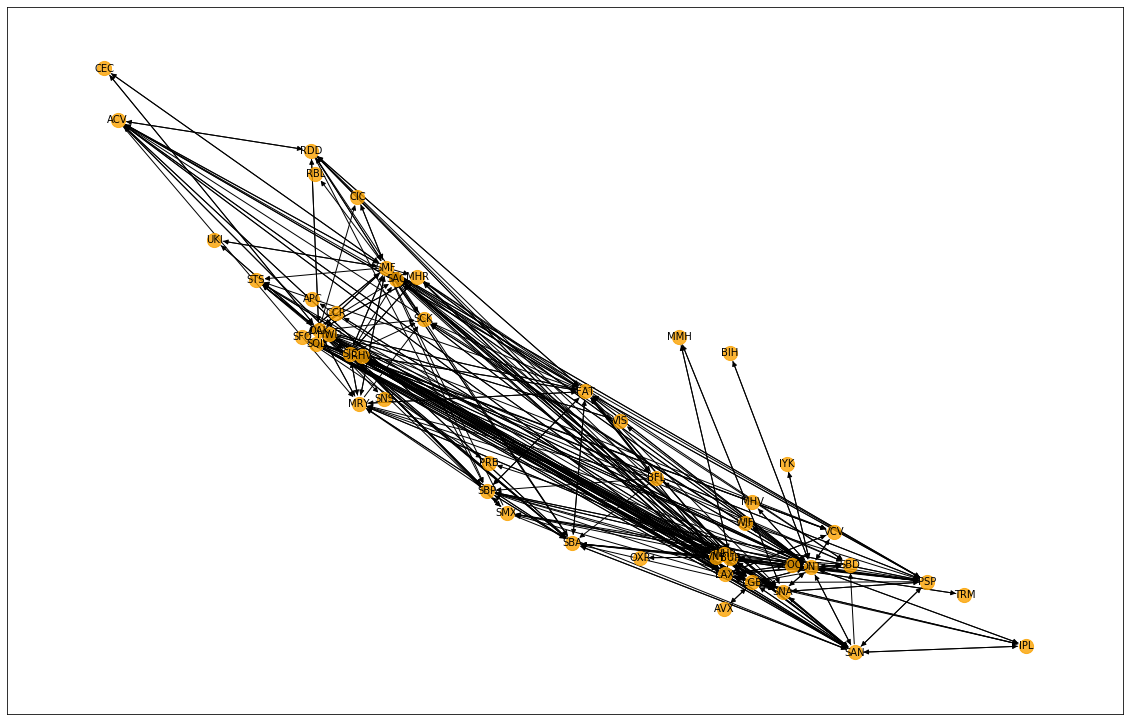

In [45]:
CA_flight_network = create_network(route_type_CA)

In [46]:
nx.write_gexf(CA_flight_network, 'ca_network_vis.gexf')

In [29]:
#checking for small-world properties
clustering = nx.average_clustering(CA_flight_network)
avg_short_path = nx.average_shortest_path_length(CA_flight_network)
length = len(CA_flight_network.nodes())
average_degree = floor(np.mean(list(dict(CA_flight_network.degree()).values())))

In [30]:
random_graph = nx.watts_strogatz_graph(length, average_degree, 1, seed=None)
clustering_random = nx.average_clustering(random_graph)
avg_shortest_path_random = nx.average_shortest_path_length(random_graph)

In [35]:
print('Clustering Coefficient for Intra-CA Flight Network: ', round(clustering, 3))
print('Clustering Coefficient for Random Graph: ', round(clustering_random, 3))
print('Average Shortest Path for Intra-CA Flight Network: ', round(avg_short_path, 3))
print('Average Shortest Path for Random Graph: ', round(avg_shortest_path_random, 3))

Clustering Coefficient for Intra-CA Flight Network:  0.503
Clustering Coefficient for Random Graph:  0.24
Average Shortest Path for Intra-CA Flight Network:  1.761
Average Shortest Path for Random Graph:  1.771


In [39]:
deg_centrality = nx.degree_centrality(CA_flight_network)
bet_centrality = nx.betweenness_centrality(CA_flight_network)

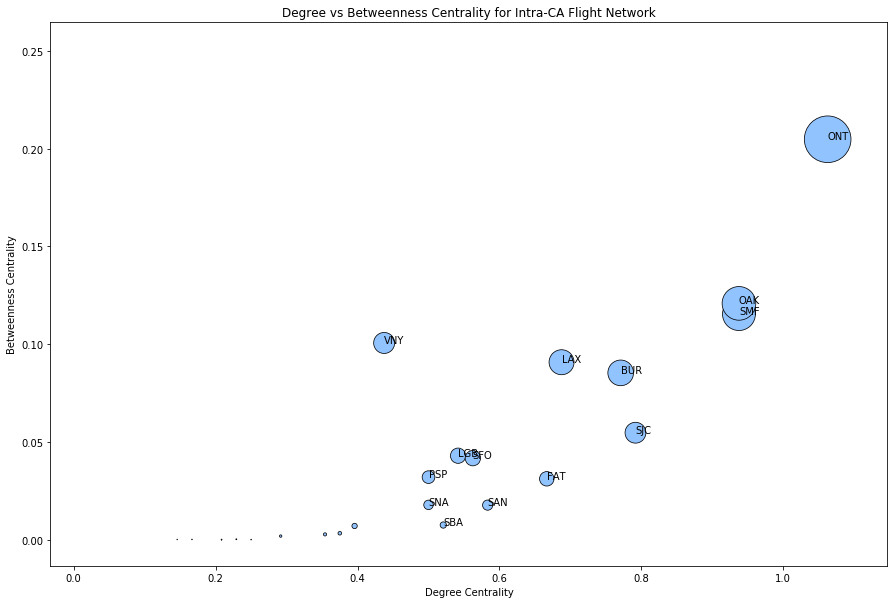

In [41]:
x = list(deg_centrality.values())
y = list(bet_centrality.values())
airport_labels = enumerate(list(deg_centrality.keys()))
s = np.multiply(x,y)*1e4
plt.figure(2, figsize=(15,10))
sns.scatterplot(x,y,s = s, color = '#91c3ff', edgecolor = 'black')
plt.xlabel('Degree Centrality');
plt.ylabel('Betweenness Centrality');
plt.title('Degree vs Betweenness Centrality for Intra-CA Flight Network');
for i, name in airport_labels:
    if deg_centrality[name] > 0.4 or bet_centrality[name] > 0.02:
        plt.annotate(name, (x[i], y[i]))